In [4]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.manifold import TSNE
from pprint import pprint
import urllib.request
import random
import re
import torch._dynamo
import os
from torch.optim.lr_scheduler import StepLR

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
response = urllib.request.urlopen(url)
sherlock_text = response.read().decode("utf-8")
sherlock_text = sherlock_text[1504:]

In [7]:
def generate_word_prediction_dataset(text, block_size=5, print_limit=20):
    sentences = re.split(r'\.\s+|\r\n\r\n', text)
    cleaned_sentences = [
        re.sub(r'[^a-zA-Z0-9 ]', ' ', sentence).strip()
        for sentence in sentences
    ]

    cleaned_sentences = [s for s in cleaned_sentences if len(s.split()) >= 2]

    words = [word for sentence in cleaned_sentences for word in sentence.split()]

    vocabulary = set(words)
    
    stoi = {word: i + 1 for i, word in enumerate(vocabulary)}
    stoi["."] = 0 
    itos = {i: word for word, i in stoi.items()}
    itos[0] = "." 

    X, Y = [], [] 
    count = 0 

    for sentence in cleaned_sentences:
        sentence_words = sentence.split() 
        context = [0] * block_size  
        for word in sentence_words + ['.']: 
            ix = stoi[word]  
            X.append(context) 
            Y.append(ix) 

            if count < print_limit:
                print(' '.join(itos[i] for i in context), '--->', itos[ix])
                count += 1
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(f"Dataset generated with {len(X)} samples")
    return X, Y, stoi, itos

X, Y, stoi, itos = generate_word_prediction_dataset(sherlock_text, block_size=5, print_limit=20)

. . . . . ---> A
. . . . A ---> SCANDAL
. . . A SCANDAL ---> IN
. . A SCANDAL IN ---> BOHEMIA
. A SCANDAL IN BOHEMIA ---> .
. . . . . ---> To
. . . . To ---> Sherlock
. . . To Sherlock ---> Holmes
. . To Sherlock Holmes ---> she
. To Sherlock Holmes she ---> is
To Sherlock Holmes she is ---> always
Sherlock Holmes she is always ---> the
Holmes she is always the ---> woman
she is always the woman ---> .
. . . . . ---> I
. . . . I ---> have
. . . I have ---> seldom
. . I have seldom ---> heard
. I have seldom heard ---> him
I have seldom heard him ---> mention
Dataset generated with 115262 samples


In [8]:
len(stoi)

8794

In [9]:
print(stoi)

{'passionately': 1, 'deprived': 2, 'indirect': 3, 'choosing': 4, 'by': 5, 'produced': 6, 'brawls': 7, 'persecution': 8, 'buzzing': 9, 'ugly': 10, 'sallow': 11, 'opium': 12, 'region': 13, 'bore': 14, 'hired': 15, 'cheating': 16, 'swollen': 17, 'pained': 18, 'green': 19, 'postpone': 20, 'will': 21, 'stooping': 22, 'slammed': 23, 'Two': 24, 'desire': 25, 'then': 26, 'rising': 27, 'cracked': 28, 'rapid': 29, 'Father': 30, 'astuteness': 31, 'train': 32, 'raised': 33, 'line': 34, '2': 35, 'writhing': 36, 'expecting': 37, 'Hers': 38, 'cost': 39, 'rushing': 40, 'does': 41, 'cut': 42, 'firemen': 43, 'chaff': 44, 'banking': 45, 'raved': 46, 'answer': 47, 'men': 48, 'fit': 49, 'shillings': 50, 'guineas': 51, 'apparently': 52, 'marriage': 53, 'murdered': 54, 'wardrobe': 55, 'small': 56, 'arrest': 57, 'extending': 58, 'Alexander': 59, 'confirm': 60, 'penal': 61, 'dear': 62, 'expression': 63, 'limb': 64, 'ways': 65, 'leaves': 66, 'Stoner': 67, 'wrenching': 68, 'stairs': 69, 'They': 70, 'smoke': 71, 

In [2]:
print("X tensor shape:", X.shape)
print("y tensor shape:", Y.shape)


NameError: name 'X' is not defined

In [16]:
class NextWord(nn.Module):
    
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation_fn='ReLU'):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        if activation_fn == 'ReLU':
            self.activation = nn.ReLU()
        elif activation_fn == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'tanh'.")

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x)) 
        x = self.lin2(x)
        return x


In [17]:
def save_model(model, embedding_size, context_length, activation_fn):
    model_name = f"model_emb{embedding_size}_ctx{context_length}_act{activation_fn}.pth"
    torch.save(model.state_dict(), model_name)
    print(f"Model saved as {model_name}")


In [18]:
def generate_text(model, itos, stoi, block_size, input_sentence, max_len=100):
    input_indices = [stoi.get(word, 0) for word in input_sentence.split()]
    context = [0] * max(0, block_size - len(input_indices)) + input_indices[-block_size:]
    generated_text = input_sentence.strip() + ' '
    
    for _ in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        next_word = itos[ix]
        generated_text += next_word + ' '
        context = context[1:] + [ix]
    
    generated_text = generated_text.replace(' .', '.')
    
    return generated_text.strip()

In [20]:
os.environ["PYTORCH_ENABLE_TRITON"] = "0"
torch._dynamo.config.suppress_errors = True

loss_fn = nn.CrossEntropyLoss()

hidden_size = 1024
batch_size = 4096
print_every =50
num_epochs = 500

for emb_dim in [128]:
    for block_size in [15]:
        for activation_function in ["Tanh"]:
            X_tensor, y_tensor, stoi, itos = generate_word_prediction_dataset(sherlock_text, block_size = block_size, print_limit = 10)
            model = NextWord(block_size, len(stoi), emb_dim, hidden_size, activation_function).to(device)
            
            opt = torch.optim.AdamW(model.parameters(), lr=0.01)
            scheduler = StepLR(opt, step_size=50, gamma=0.1)
            X_tensor.to(device)
            y_tensor.to(device)
            for epoch in range(num_epochs):
                for i in range(0, X_tensor.shape[0], batch_size):
                    x = X_tensor[i:i + batch_size].to(device)
                    y = y_tensor[i:i + batch_size].to(device)
                    y_pred = model(x)
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                scheduler.step()
                if (epoch+1) % print_every == 0:
                    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
            save_model(model, emb_dim, block_size, activation_function)
           

. . . . . . . . . . . . . . . ---> A
. . . . . . . . . . . . . . A ---> SCANDAL
. . . . . . . . . . . . . A SCANDAL ---> IN
. . . . . . . . . . . . A SCANDAL IN ---> BOHEMIA
. . . . . . . . . . . A SCANDAL IN BOHEMIA ---> .
. . . . . . . . . . . . . . . ---> To
. . . . . . . . . . . . . . To ---> Sherlock
. . . . . . . . . . . . . To Sherlock ---> Holmes
. . . . . . . . . . . . To Sherlock Holmes ---> she
. . . . . . . . . . . To Sherlock Holmes she ---> is
Dataset generated with 115262 samples
Epoch: 50, Loss: 0.6648274064064026
Epoch: 100, Loss: 0.41341692209243774
Epoch: 150, Loss: 0.3885379433631897
Epoch: 200, Loss: 0.38725540041923523
Epoch: 250, Loss: 0.38713788986206055
Epoch: 300, Loss: 0.3871264159679413
Epoch: 350, Loss: 0.3871230185031891
Epoch: 400, Loss: 0.3871229887008667
Epoch: 450, Loss: 0.3871229887008667
Epoch: 500, Loss: 0.3871229887008667
Model saved as model_emb128_ctx15_actTanh.pth


In [21]:
# Generate sample words
input = "Hi"
print(generate_text(model, itos, stoi, block_size,input, 1000))


Hi I want to see whether the objections are fatal or if they may be explained away.. and west duties this girl Miss Stoner desire to leave you not which that which he is not. in up to turn me. not. Drive help striking volunteers this morning are even night we must be gone advice that I could good you come with that. right. the skylight of being one of the fourth prey. out of the woman of the three. in the South. and I. with the address of the Gravesend. in the me. of the or cases a barmaid strange stalls F. which and the money. of mere saw his room. to continue.. by the police into the bedroom.. owner over his father... out in the direction of the two marks with this dark and visiting the inspector which has his more or. of Here Watson. of the father should ask likely that they may have been bent to our strange the body in the country of the limbs and not use of the assistant and I have felt best club that to employ the matter. of my wife died I was one to my friend and on the clothes 

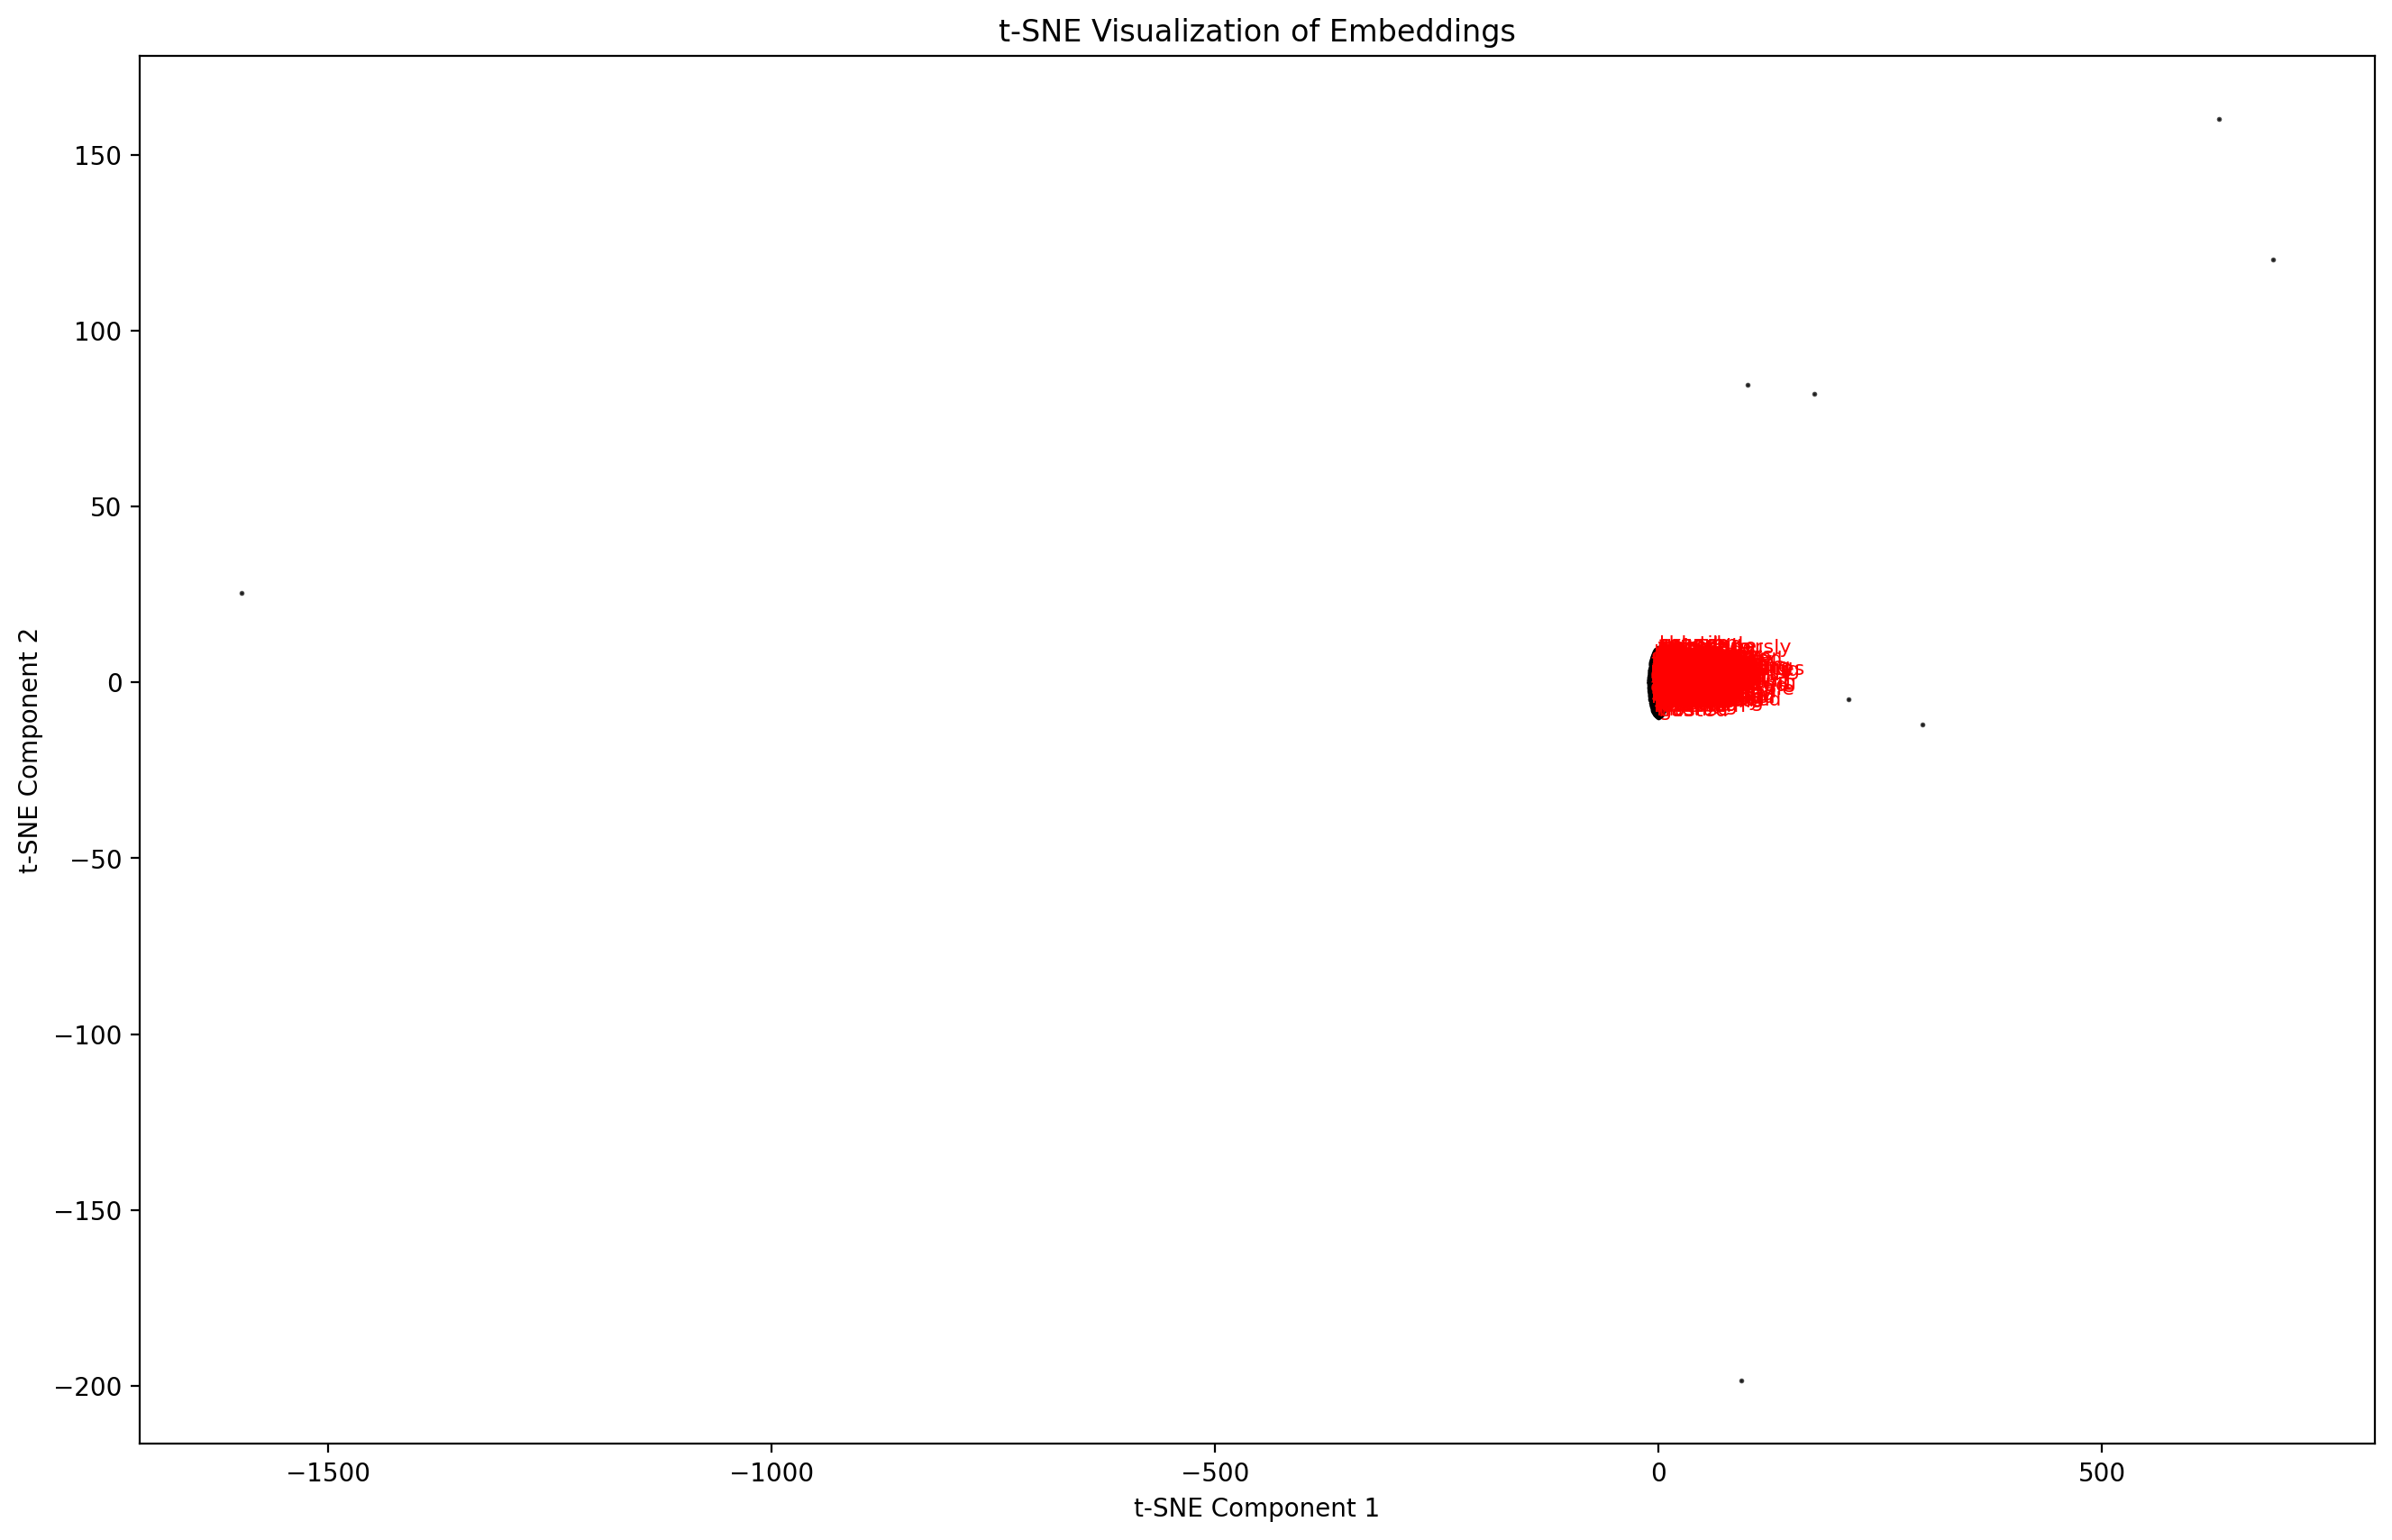

In [22]:
def plot_emb(emb, itos, ax=None, num_points_to_label=100):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
    emb_weights = emb.weight.detach().cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    emb_2d = tsne.fit_transform(emb_weights)
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], color='k', s=1, alpha=0.7)

    indices = np.random.choice(len(itos), num_points_to_label, replace=False)

    for i in indices:
        ax.text(emb_2d[i, 0] + 0.05, emb_2d[i, 1] + 0.05, itos[i], fontsize=8, color='red')
        
    ax.set_title('t-SNE Visualization of Embeddings')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    return ax

plot_emb(model.emb, itos, num_points_to_label=300)
plt.show()


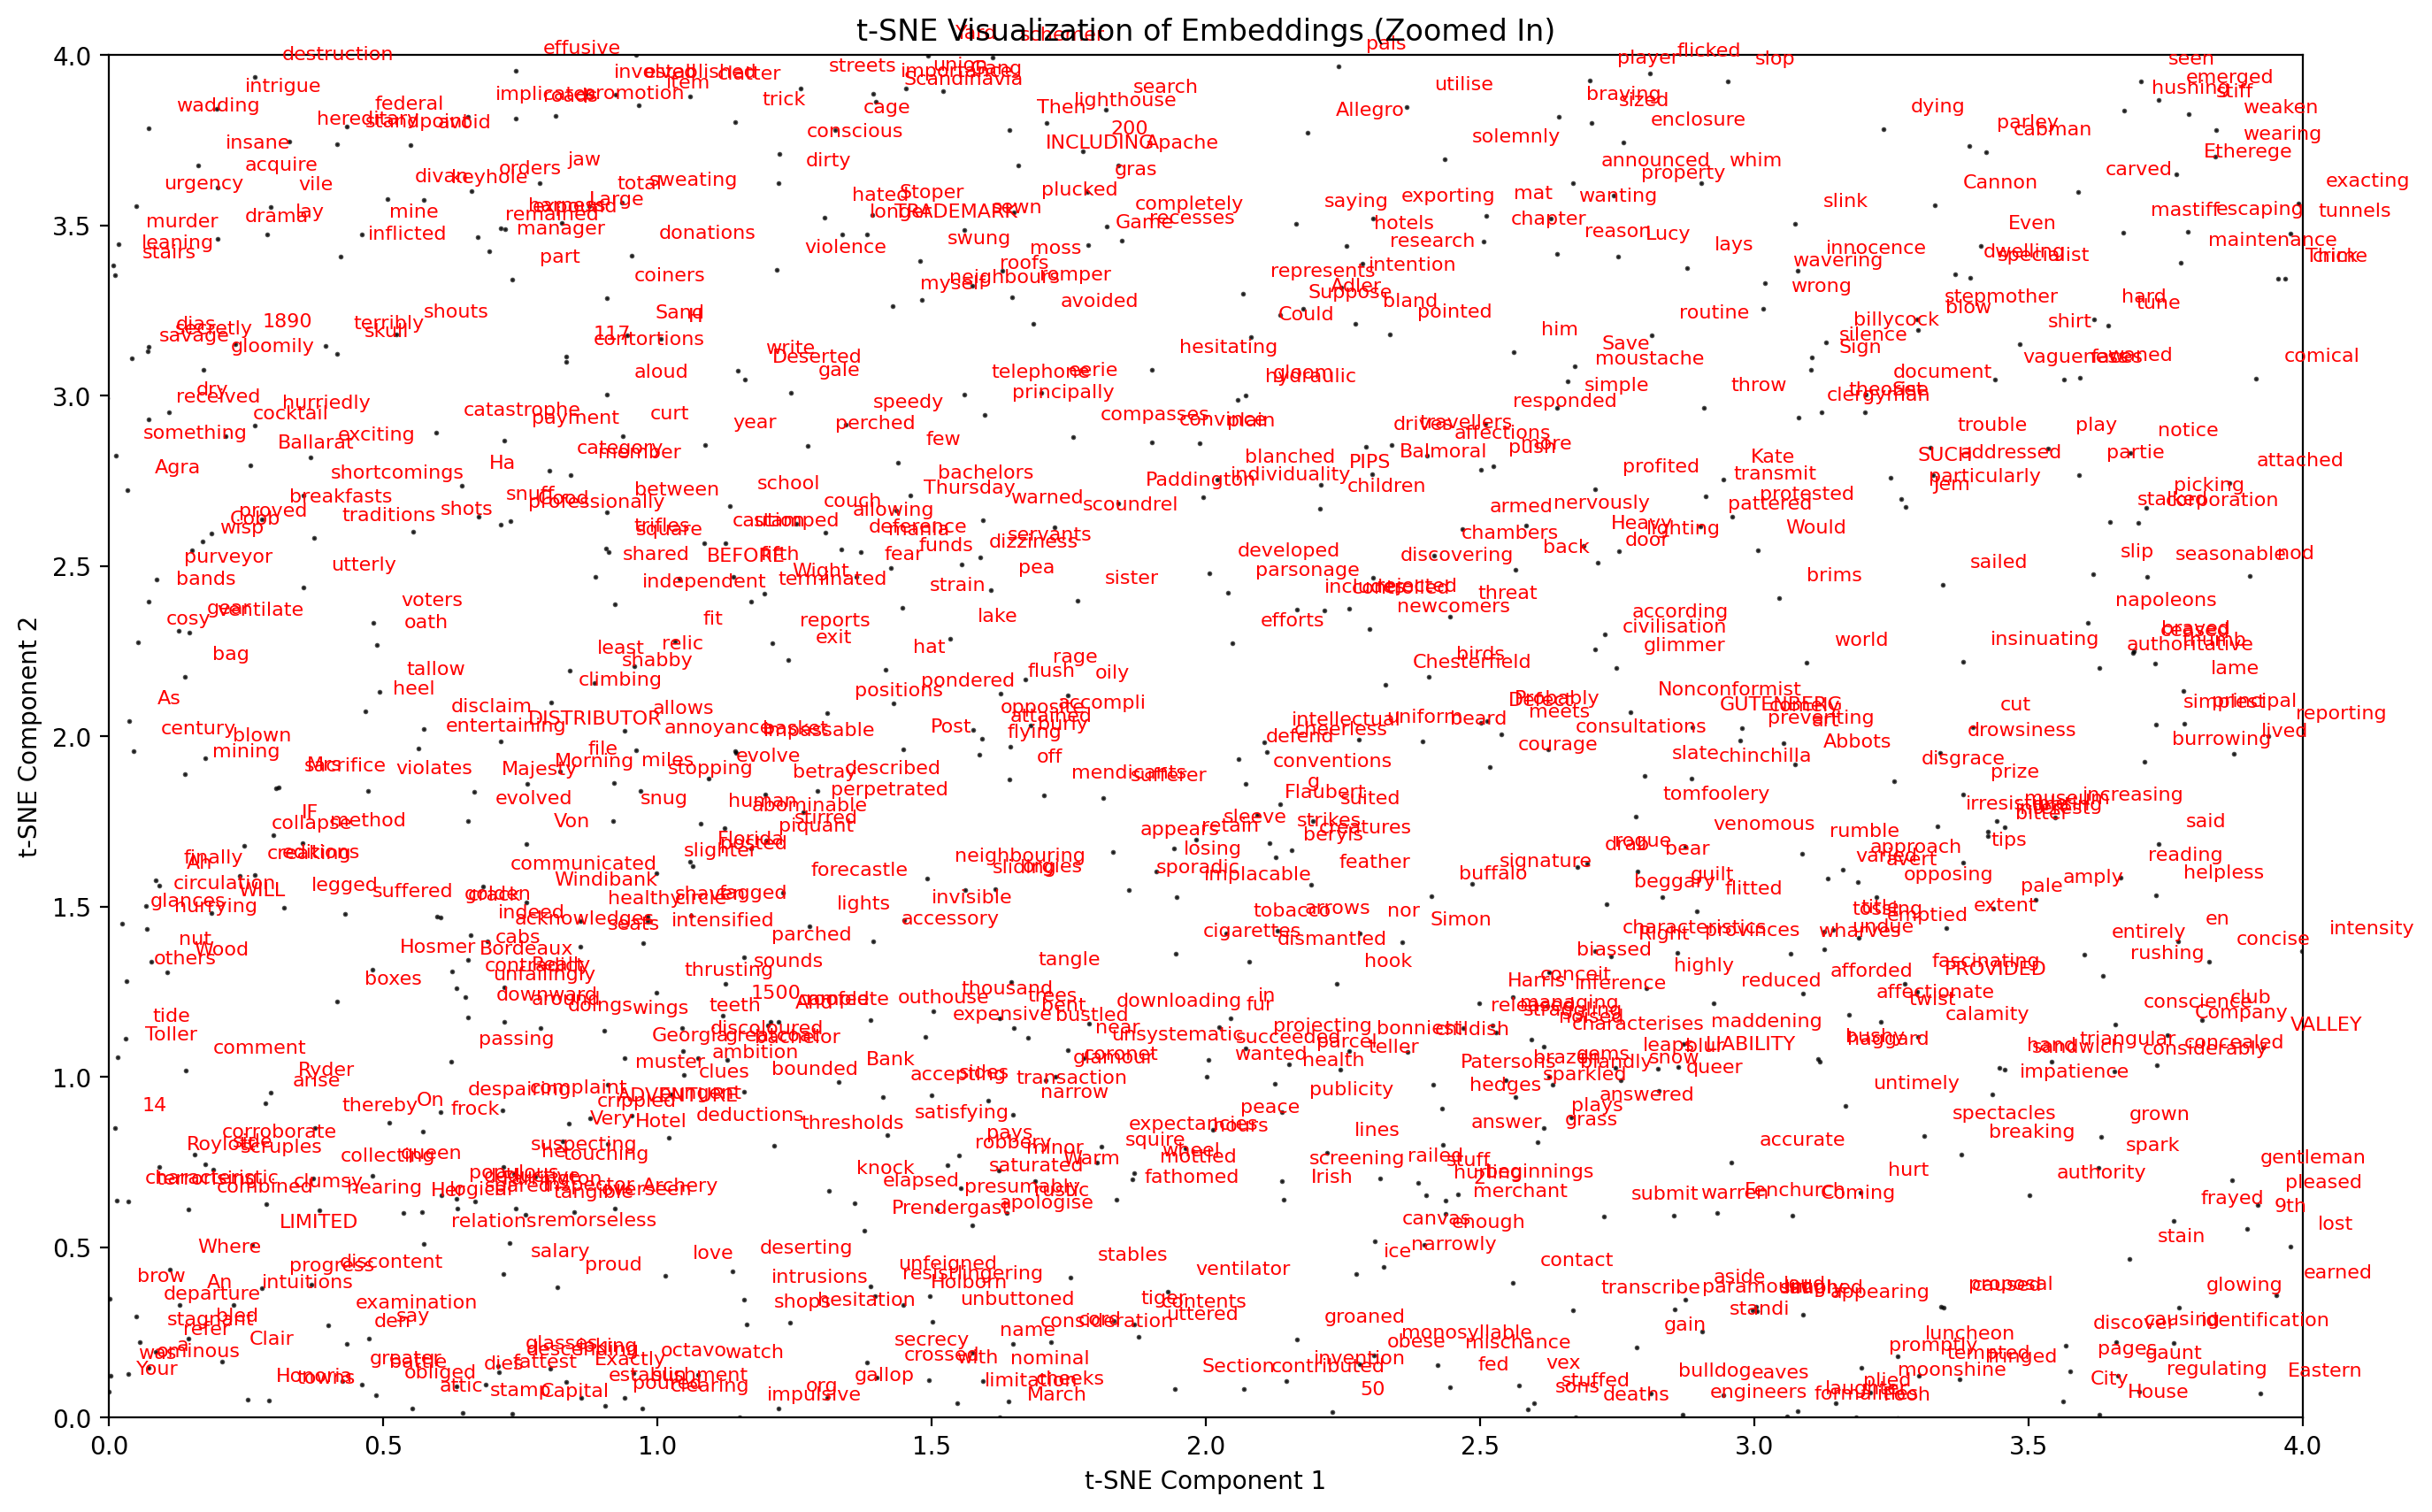

In [23]:
def plot_emb(emb, itos, ax=None, num_points_to_label=100, x_range=None, y_range=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
    emb_weights = emb.weight.detach().cpu().numpy()
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    emb_2d = tsne.fit_transform(emb_weights)

    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], color='k', s=1, alpha=0.7)
    if x_range and y_range:
        mask = (emb_2d[:, 0] > x_range[0]) & (emb_2d[:, 0] < x_range[1]) & \
               (emb_2d[:, 1] > y_range[0]) & (emb_2d[:, 1] < y_range[1])
        indices = np.where(mask)[0]
    else:

        indices = np.random.choice(len(itos), num_points_to_label, replace=False)

    for i in indices:
        ax.text(emb_2d[i, 0] + 0.05, emb_2d[i, 1] + 0.05, itos[i], fontsize=8, color='red')
    if x_range:
        ax.set_xlim(x_range)
    if y_range:
        ax.set_ylim(y_range)
        
    ax.set_title('t-SNE Visualization of Embeddings (Zoomed In)')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    return ax
plot_emb(model.emb, itos, num_points_to_label=50, x_range=(0, 4), y_range=(0, 4))
plt.show()
